<a href="https://colab.research.google.com/github/bhogasena/Automatic_Ticket_Classification/blob/main/Automatic_Ticket_Classification_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
!pip install swifter


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 830.9/830.9 KB 18.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 KB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 68.9 MB/s eta 0:00:00
  Created wheel for swifter: filename=swifter-1.3.4-py3-none-any.whl size=16321 sha256=14bdb0d247a43e4d8fc760d177f9168ed68e4d5e18d62fb3726fffbd8f44a809
  Stored in directory: /root/.cache/pip/wheels/08/66/b4/921e351e63d88696932279d6163e125727c9da70ed8ca38419
Successfully built swifter
  Attempting uninstall: psutil
    Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Successfully uninstalled psutil-5.4.8


In [3]:
!pip install --upgrade numpy
!pip install --upgrade gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 79.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.7.3 requires numpy<1.23.0,>=1.16.5, but you have numpy 1.24.1 which is incompatible.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.24.1 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 95.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.1
    Uninstalling numpy-1.24.1:
      Successfully unins

# **Please note after PIP upgrade need to restart Machine else errors will occur on Gensim module**

In [64]:
import json 
import numpy as np
import pandas as pd
import swifter
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
import ast
%matplotlib inline
from nltk import word_tokenize
from nltk.util import ngrams
from collections import Counter

from nltk.corpus import stopwords
from wordcloud import WordCloud


from gensim.corpora.dictionary import Dictionary
# from gensim.models import Nmf
from gensim.models.nmf import Nmf
from gensim.models.coherencemodel import CoherenceModel
from operator import itemgetter

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB

from pprint import pprint

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [3]:
# Opening JSON file 
f = open("complaints-2021-05-14_08_16.json","r")# Write the path to your data file and load it 
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [4]:
# Inspect the dataframe to understand the given data.
df.head(5)


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [5]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [6]:
#Assign new column names
df.columns = df.columns.str.replace('_source.','') # substitute '_source.' with ''
df.rename(columns={'complaint_what_happened':'Complaints'},inplace=True)
df.columns

Index(['_index', '_type', '_id', '_score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely', 'Complaints',
       'sub_issue', 'consumer_consent_provided'],
      dtype='object')

In [7]:
print(df.shape)

(78313, 22)


In [8]:
#Assign nan in place of blanks in the complaints column
df['Complaints'] = df['Complaints'].apply(lambda x: x.strip()).replace('',np.NaN)

In [9]:
#Remove all rows where complaints column is nan
df.dropna(subset=['Complaints'], inplace=True)
print(df.shape)

(21072, 22)


In [10]:
pd.options.display.max_colwidth=None

In [11]:
df.Complaints.head(10) #display Complaints of first two rows

1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [12]:
# Write your function here to clean the text and remove all the unnecessary elements.
df['Complaints'] = df['Complaints'].str.lower() # convert text to lower case
df['Complaints'] = df['Complaints'].str.replace(r'\[.*\]','',regex=True) # remove text in square brackets
df['Complaints'] = df['Complaints'].str.replace(r'\{.*\}','',regex=True) # remove text in curly brackets

#remove punctuations
# Get the string of all punctuation characters
punctuation = string.punctuation

# Define a translation table to remove punctuation
translator = str.maketrans('', '', punctuation)

df['Complaints'] = df['Complaints'].apply(lambda x: x.translate(translator))

df['Complaints'] = df['Complaints'].str.replace(r'\d','',regex=True) # remove digits

In [13]:
#Write your function to Lemmatize the texts
def get_lemamatize_text(text):
  doc = nlp(text)
  return ' '.join([token.lemma_ for token in doc])

In [14]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 

# df['Lemmatize_Complaints'] = df['Complaints'].swifter.apply(lambda x: get_lemamatize_text(x))

# create Lemmatization text for each complaint text
lemma = []
noun_text = []
for doc in nlp.pipe(df['Complaints'].astype('unicode').values, batch_size=50,
                        n_process=-1):
    if doc.has_annotation("DEP"):
        lemma.append(' '.join([token.lemma_ for token in doc]))
        temp_noun_text=[]

        # get Noun words only
        for token in doc:          
          if token.tag_== "NN":
            temp_noun_text.append(token.text)
        noun_text.append(' '.join(temp_noun_text))      

    else:
        # We want to make sure that the lists of parsed results have the
        # same number of entries of the original Dataframe, so add some blanks in case the parse fails
        lemma.append(None)
        noun_text.append(None)
df['Lemmatize_Complaints'] = lemma
df["complaint_POS_removed"] = noun_text

# create new data frame with two columns Complaints and Lemmatize_Complaints.

df_clean = pd.DataFrame(df, columns=['Complaints','Lemmatize_Complaints', 'complaint_POS_removed'])

In [15]:
df["complaint_POS_removed"].head(5)

1                                                                                                                                                                                                                                             morning name stop debt verification statement bank debt mail month debt right information consumer chase account advance help
2                                                                                                                                                                                                                                                                           agent anniversary date agent information order account anniversary date consent recording agent
10                                                                                                                                                                                                                                                                              

In [16]:
df_clean = pd.DataFrame(df, columns=['Complaints','Lemmatize_Complaints','complaint_POS_removed'])

In [17]:
df_clean.to_csv("df_clean.csv") # write clean dataframe to csv

In [18]:
#Write your function to extract the POS tags 

def pos_tag(text):
    doc = nlp(text)
    return [token.pos_ for token in doc]


In [19]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head(2)

,Complaints,Lemmatize_Complaints,complaint_POS_removed
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt \n I have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name stop debt verification statement bank debt mail month debt right information consumer chase account advance help
2,i upgraded my xxxx xxxx card in xxxx and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,I upgrade my xxxx xxxx card in xxxx and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I,agent anniversary date agent information order account anniversary date consent recording agent


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




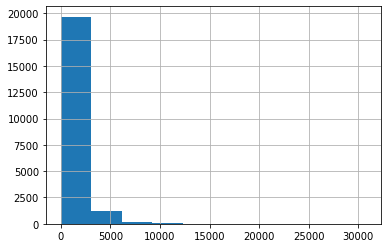

In [20]:
# Write your code here to visualise the data according to the 'Complaint' character length
df['Complaints'].str.len().hist()

#### Find the top 40 words by frequency among all the articles after processing the text.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


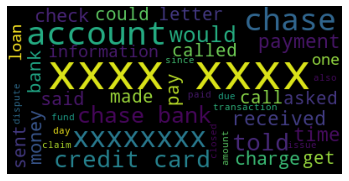

In [21]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
nltk.download('stopwords')
stops = set(stopwords.words('english'))
wc = WordCloud(stopwords =stops , max_words=40).generate(' '.join(df['Complaints']))
fig = plt.figure(1)
plt.imshow(wc)
plt.axis('off')
plt.show()

In [22]:
#Removing -PRON- from the text corpus
df_clean['complaint_POS_removed'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [23]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
token = nltk.word_tokenize(' '.join(df_clean['Complaints'].values))
unigrams = Counter(ngrams(token,1))
unigrams.most_common(30)


[(('the',), 210195),
 (('xxxx',), 179715),
 (('i',), 172520),
 (('to',), 163519),
 (('and',), 129249),
 (('a',), 95402),
 (('my',), 95296),
 (('that',), 76479),
 (('chase',), 72451),
 (('of',), 70122),
 (('was',), 69478),
 (('on',), 55837),
 (('in',), 55561),
 (('they',), 50071),
 (('for',), 48508),
 (('not',), 46727),
 (('me',), 46115),
 (('this',), 43466),
 (('have',), 41315),
 (('is',), 40119),
 (('with',), 40025),
 (('account',), 37187),
 (('it',), 34350),
 (('credit',), 29996),
 (('from',), 27049),
 (('xxxxxxxx',), 24869),
 (('bank',), 24206),
 (('as',), 24095),
 (('card',), 23917),
 (('had',), 23322)]

In [24]:
#Print the top 10 words in the unigram frequency
print(unigrams.most_common(10))

[(('the',), 210195), (('xxxx',), 179715), (('i',), 172520), (('to',), 163519), (('and',), 129249), (('a',), 95402), (('my',), 95296), (('that',), 76479), (('chase',), 72451), (('of',), 70122)]


In [25]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
bigrams = Counter(ngrams(token,2))
bigrams.most_common(30)

[(('xxxx', 'xxxx'), 65109),
 (('i', 'have'), 18180),
 (('i', 'was'), 17573),
 (('of', 'the'), 15086),
 (('that', 'i'), 13641),
 (('to', 'the'), 11966),
 (('chase', 'bank'), 11525),
 (('xxxx', 'i'), 10829),
 (('my', 'account'), 10598),
 (('in', 'the'), 10322),
 (('xxxx', 'and'), 10135),
 (('credit', 'card'), 9975),
 (('and', 'i'), 9954),
 (('i', 'am'), 9812),
 (('on', 'the'), 9201),
 (('my', 'credit'), 9169),
 (('on', 'xxxx'), 9027),
 (('on', 'xxxxxxxx'), 8923),
 (('i', 'had'), 8664),
 (('on', 'my'), 8347),
 (('for', 'the'), 8148),
 (('did', 'not'), 8069),
 (('in', 'xxxx'), 8026),
 (('that', 'the'), 7772),
 (('i', 'called'), 7012),
 (('it', 'was'), 6693),
 (('the', 'xxxx'), 6628),
 (('with', 'the'), 6571),
 (('to', 'my'), 6561),
 (('to', 'be'), 6494)]

In [26]:
#Print the top 10 words in the bigram frequency
print(bigrams.most_common(10))

[(('xxxx', 'xxxx'), 65109), (('i', 'have'), 18180), (('i', 'was'), 17573), (('of', 'the'), 15086), (('that', 'i'), 13641), (('to', 'the'), 11966), (('chase', 'bank'), 11525), (('xxxx', 'i'), 10829), (('my', 'account'), 10598), (('in', 'the'), 10322)]


In [27]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
trigrams = Counter(ngrams(token,3))
trigrams.most_common(30)

[(('xxxx', 'xxxx', 'xxxx'), 27611),
 (('xxxx', 'xxxx', 'and'), 3543),
 (('xxxx', 'xxxx', 'i'), 3428),
 (('on', 'xxxx', 'xxxx'), 3293),
 (('i', 'did', 'not'), 3144),
 (('i', 'was', 'told'), 2980),
 (('on', 'xxxxxxxx', 'i'), 2662),
 (('my', 'credit', 'report'), 2401),
 (('i', 'have', 'been'), 2387),
 (('xxxx', 'and', 'xxxx'), 2346),
 (('on', 'my', 'credit'), 2276),
 (('i', 'received', 'a'), 2196),
 (('jp', 'morgan', 'chase'), 2187),
 (('i', 'called', 'chase'), 2034),
 (('to', 'xxxx', 'xxxx'), 1995),
 (('my', 'credit', 'card'), 1874),
 (('told', 'me', 'that'), 1827),
 (('the', 'xxxx', 'xxxx'), 1808),
 (('in', 'xxxx', 'xxxx'), 1706),
 (('that', 'i', 'was'), 1680),
 (('on', 'xxxx', 'i'), 1644),
 (('from', 'xxxx', 'xxxx'), 1595),
 (('chase', 'credit', 'card'), 1578),
 (('was', 'told', 'that'), 1558),
 (('i', 'do', 'not'), 1555),
 (('at', 'xxxx', 'xxxx'), 1537),
 (('that', 'i', 'had'), 1511),
 (('the', 'amount', 'of'), 1424),
 (('i', 'have', 'a'), 1374),
 (('with', 'chase', 'bank'), 1327)]

In [28]:
#Print the top 10 words in the trigram frequency
trigrams.most_common(10)

[(('xxxx', 'xxxx', 'xxxx'), 27611),
 (('xxxx', 'xxxx', 'and'), 3543),
 (('xxxx', 'xxxx', 'i'), 3428),
 (('on', 'xxxx', 'xxxx'), 3293),
 (('i', 'did', 'not'), 3144),
 (('i', 'was', 'told'), 2980),
 (('on', 'xxxxxxxx', 'i'), 2662),
 (('my', 'credit', 'report'), 2401),
 (('i', 'have', 'been'), 2387),
 (('xxxx', 'and', 'xxxx'), 2346)]

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [29]:
df_clean['complaint_POS_removed'] = df_clean['complaint_POS_removed'].str.replace('xxxx','')

In [30]:
#All masked texts has been removed
df_clean

,Complaints,Lemmatize_Complaints,complaint_POS_removed
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt \n I have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name stop debt verification statement bank debt mail month debt right information consumer chase account advance help
2,i upgraded my xxxx xxxx card in xxxx and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,I upgrade my xxxx xxxx card in xxxx and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I,agent anniversary date agent information order account anniversary date consent recording agent
10,chase card was reported on xxxx however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on xxxx however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,chase card application identity consent credit identity applicant
11,on xxxx while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than minutes of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than mins after putting in the application on xxxx notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on xxxx this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,on xxxx while try to book a xxxx xxxx ticket I come across an offer for to be apply towards the ticket if I apply for a reward card I put in my information for th

## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [31]:
#Write your code here to initialise the TfidfVectorizer 

tfidf=TfidfVectorizer(max_df=0.95,min_df=2,stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [32]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm=tfidf.fit_transform(df_clean['complaint_POS_removed'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [33]:
from sklearn.decomposition import NMF

## Automatic Topic Modeling (To get best number of Topics using Coherence Score)

As we need to pass the best number of topics for sklearn NMF model we need to find that value. Instead of checking this manually we can use Cohence score of different models and take the highest score model and this can be calculated using gensim library.

In [34]:
# Use Gensim's NMF to get the best num of topics via coherence score
texts = df_clean['complaint_POS_removed']
data_set = [x.split() for x in texts]

# Creating a dictionary
# In gensim a dictionary is a mapping between words and their integer id
dictionary = Dictionary(data_set)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(
    no_below=2,
    no_above=0.95,
    keep_n=5000
)

# Creating the bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in data_set]

# Create a list of the topic numbers we want to try
topic_num = list(np.arange(5, 10, 1))

# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores = []

for num in topic_num:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=40
    )
    
    # Run the coherence model to get the score
    coherence_model = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(coherence_model.get_coherence(), 5))

# Get the number of topics with the highest coherence score
scores = list(zip(topic_num, coherence_scores))
best_topics_num = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

print(best_topics_num)

/usr/local/lib/python3.8/dist-packages/gensim/topic_coherence/direct_confirmation_measure.py:204: RuntimeWarning:

divide by zero encountered in double_scalars

/usr/local/lib/python3.8/dist-packages/gensim/topic_coherence/indirect_confirmation_measure.py:323: RuntimeWarning:

invalid value encountered in double_scalars



5


### As per Above Coherence scores, we got the 

**best number of topics as "5"**

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [35]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics,random_state=40, max_iter=300) #write your code here

In [36]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names())

5434

In [37]:
#Print the Top15 words for each of the topics
for index, topic in enumerate(nmf_model.components_):
    print(f'TOP 15 WORDS FOR TOPIC #{index}')
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

TOP 15 WORDS FOR TOPIC #0
['phone', 'letter', 'service', 'customer', 'merchant', 'fee', 'time', 'company', 'balance', 'dispute', 'fraud', 'charge', 'credit', 'chase', 'card']


TOP 15 WORDS FOR TOPIC #1
['bureau', 'history', 'theft', 'payment', 'limit', 'company', 'identity', 'bureaus', 'information', 'reporting', 'debt', 'score', 'inquiry', 'report', 'credit']


TOP 15 WORDS FOR TOPIC #2
['date', 'sale', 'house', 'letter', 'month', 'rate', 'foreclosure', 'property', 'time', 'modification', 'home', 'chase', 'mortgage', 'payment', 'loan']


TOP 15 WORDS FOR TOPIC #3
['deposit', 'fee', 'bank', 'access', 'overdraft', 'information', 'number', 'branch', 'reason', 'payment', 'business', 'balance', 'chase', 'checking', 'account']


TOP 15 WORDS FOR TOPIC #4
['customer', 'day', 'phone', 'number', 'person', 'atm', 'fraud', 'deposit', 'transaction', 'branch', 'claim', 'chase', 'bank', 'money', 'check']




In [38]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

topic_result = nmf_model.transform(dtm)


In [39]:
#Assign the best topic to each of the cmplaints in Topic Column
df_clean['Topic'] = topic_result.argmax(axis=1) #write your code to assign topics to each rows.

In [40]:
df_clean.head()

,Complaints,Lemmatize_Complaints,complaint_POS_removed,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt \n I have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name stop debt verification statement bank debt mail month debt right information consumer chase account advance help,3
2,i upgraded my xxxx xxxx card in xxxx and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,I upgrade my xxxx xxxx card in xxxx and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I,agent anniversary date agent information order account anniversary date consent recording agent,3
10,chase card was reported on xxxx however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on xxxx however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,chase card application identity consent credit identity applicant,1
11,on xxxx while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than minutes of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than mins after putting in the application on xxxx notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on xxxx this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,on xxxx while try to book a xxxx xxxx ticket I come across an offer for to be apply towards the ticket if I apply for a reward card I put in my inform

In [41]:
#Print the first 5 Complaint for each of the Topics
df_clean_5=df_clean.groupby('Topic').head(5)
df_clean_5.sort_values('Topic')

,Complaints,Lemmatize_Complaints,complaint_POS_removed,Topic
63,i tried to send almost,I try to send almost,,0
59,i currently have over xxxx chase ultimate rewards points which are worth at least \n\naround xxxx months ago when i tried to access my chase ultimate rewards account or even activate the bonus on chase freedom i would get shown this page that says we are unable to complete your request at this time image attached as well xxxx xxxx at first i thought it was just a temporary error which isnt uncommon for chase but after weeks this was still happening so i called customer support they opened a ticket got escalated to their tech team but when i would call back to find out what happened they told me that the case had been closed this happened times and each call has taken a lot of time to explain the situation and verify a bunch of information \n\ngoing from ultimaterewardscom and chasecom have the same result \n\nim not able to use these points by phone either because the operators for the travel center are not able to access my accountpoints neither \n\nive tried every browser both xxxx and xxxx computers and the xxxx chase phone application they all send me to the page that says we are unable to complete your request at this time on xxxxxxxx i looked up some people that work in ultimate rewards on xxxx and cold called a vp of customer relations he acted like he was helpful at first and we exchanged some emails he eventually said i can buy a flighthotel using chase sapphire and if i give him the details he will deduct the appropriate points and credit my credit card for the purchase \n\nlong story short he wasnt able to fix anything \n\ni can see that im still collecting points but i havent been able to access it \n\ni travel a lot and its become a huge inconvenience that im not able to access these points which i intended to use for travel i need to get this issue resolved asap,I currently have over xxxx chase ultimate reward point which be worth at least \n\n around xxxx month ago when I try to access my chase ultimate reward account or even activate the bonus on chase freedom I would get show this page that say we be unable to complete your request at this time image attach as well xxxx xxxx at first I think it be just a temporary error which be not uncommon for chase but after week this be still happen so I call customer support they open a ticket got escalate to their tech team but when I would call back to find out what happen they tell I that the case have be close this happen time and each call have take a lot of time to explain the situation and verify a bunch of information \n\n go from ultimaterewardscom and chasecom have the same result \n\n I m not able to use these point by phone either because the operator for the travel center be not able to access my accountpoint neither \n\n I ve try every browser both xxxx and xxxx computer and the xxxx chase phone application they all send I to the page that say we be unable to complete your request at this time on xxxxxxxx I look up some people that work in ultimate reward on xxxx and cold call a vp of customer relation he act like he be helpful at first and we exchange some email he eventually say I can buy a flighthotel use chase sapphire and if I give he the detail he will deduct the appropriate point and credit my credit card for the purchase \n\n long story short he be not able to fix anything \n\n I can see that I m still collect point but I have not be able to access it \n\n I travel a lot and its become a huge inconvenience that I m not able to access these point which I intend to use for travel I need to get this issue resolve asap,chase bonus chase freedom page request time image error chase customer support ticket tech team case call lot time situation bunch information result phone travel center browser phone application page request time vp customer flighthotel chase sapphire credit credit card purchase story anything lot inconvenience travel issue as

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [42]:
#Create the dictionary of Topic names and Topics

Topic_names = {0:"Others",
               1:"Theft/Dispute Reporting",
               2:"Mortgage/Loan",
               3:"Credit card or prepaid card",
               4:"Bank Account services"}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [43]:
df_clean

,Complaints,Lemmatize_Complaints,complaint_POS_removed,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt \n I have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name stop debt verification statement bank debt mail month debt right information consumer chase account advance help,Credit card or prepaid card
2,i upgraded my xxxx xxxx card in xxxx and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,I upgrade my xxxx xxxx card in xxxx and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I,agent anniversary date agent information order account anniversary date consent recording agent,Credit card or prepaid card
10,chase card was reported on xxxx however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on xxxx however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,chase card application identity consent credit identity applicant,Theft/Dispute Reporting
11,on xxxx while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than minutes of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than mins after putting in the application on xxxx notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on xxxx this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,on xxxx while try to book a xxxx xxxx ticket I come across an offer for to b

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [44]:
#Create the dictionary again of Topic names and Topics

Topic_names = { "Others":0,
               "Theft/Dispute Reporting":1,
               "Mortgage/Loan":2,
               "Credit card or prepaid card":3,
               "Bank Account services":4  }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [45]:
df_clean

,Complaints,Lemmatize_Complaints,complaint_POS_removed,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt \n I have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name stop debt verification statement bank debt mail month debt right information consumer chase account advance help,3
2,i upgraded my xxxx xxxx card in xxxx and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,I upgrade my xxxx xxxx card in xxxx and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I,agent anniversary date agent information order account anniversary date consent recording agent,3
10,chase card was reported on xxxx however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on xxxx however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,chase card application identity consent credit identity applicant,1
11,on xxxx while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than minutes of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than mins after putting in the application on xxxx notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on xxxx this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,on xxxx while try to book a xxxx xxxx ticket I come across an offer for to be apply towards the ticket if I apply for a reward card I put in my inform

In [46]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data = df_clean[['Complaints','Topic']]

In [47]:
training_data

,Complaints,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,3
2,i upgraded my xxxx xxxx card in xxxx and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,3
10,chase card was reported on xxxx however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,1
11,on xxxx while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than minutes of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than mins after putting in the application on xxxx notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on xxxx this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,1
14,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen xxxx check number xxxx claim number is xxxx with chase,4
...,...,...
78303,after being a chase card customer for well over a decade was offered multiple solicitations for acquiring new credit cards with chase all with bonus airline miles and hotel points was approved for all new cards with no annual fee for st year after less than months with payment always paid as agreed chase closed all my cards one of my approved new cards was never activated but was sent to me\n\nchase has done harm to my credit has charged me an annual fee even though they cancelled my account failed to credit my points for both airlines and hotel failed to credit up to for xxxx enrollment and failed to credit airline charge as agreed upon,0
78309,on wednesday xxxxxxxx i called chas my xxxx xxxx visa credit card provider and asked how to make a claim under their purchase protection benefit on xxxxxxxx i purchased three high school textbooks for my xxxx year old daughter because she transferred to a new school all three books were damaged when a water bottle in her backpack broke the c

## Data Visulazation

Plot the histogram to check distribution of topics

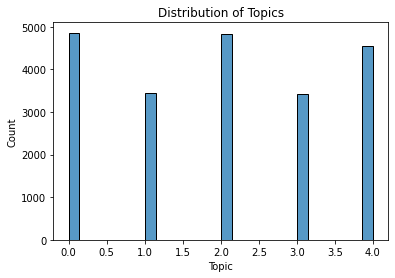

In [48]:
sns.histplot(data=training_data, x='Topic' )
plt.title("Distribution of Topics")
plt.show()

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [49]:

#Write your code to get the Vector count
count_vector=CountVectorizer()
complaints_vector=count_vector.fit_transform(training_data['Complaints']) # fit the count vector on Complaints

#Write your code here to transform the word vector to tf-idf
tfidf_transform= TfidfTransformer()
complaints_tfid = tfidf_transform.fit_transform(complaints_vector)

#Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(complaints_tfid, training_data.Topic, test_size=0.25, random_state=99)

print(f"X_train Shape: {X_train.shape}")
print(f"y_train Shape: {y_train.shape}")
print(f"X_test Shape: {X_test.shape}")
print(f"y_test Shape: {y_test.shape}")

X_train Shape: (15804, 32242)
y_train Shape: (15804,)
X_test Shape: (5268, 32242)
y_test Shape: (5268,)


You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

# Model 1: Logistic regression

In [50]:
lr = LogisticRegression() 


In [51]:
# Hyperparameter tuning for best result
param_lr = {
    'penalty': ['l1', 'l2'],
    'C': [0.001,0.01,0.1,1,10,100],
    'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

grid_lr = GridSearchCV(estimator=lr, 
                       param_grid=param_lr,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=5)
grid_lr.fit(X_train, y_train)
print(grid_lr.best_params_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning:


90 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueError: Solver

{'C': 1, 'penalty': 'l1', 'solver': 'saga'}


In [52]:
# Creating model with best hyperparameter
logistic_model = LogisticRegression(C=1, 
                                  penalty='l1', 
                                  solver='saga')

logistic_model.fit(X_train, y_train)
logistic_model_pred = logistic_model.predict(X_test)

In [71]:
# Create a function to evaluate models
def model_eval(y_test, y_pred, model_name):

    f1score = f1_score(y_test, y_pred, average="weighted")
    
    #print f1-score
    print(f"F1-Score for {model_name} is {f1score}" )


    # print classification report of classifier
    print(f"CLASSIFICATION REPORT for {model_name}\n")
    print(classification_report(y_test, y_pred, target_names=["Others", "Theft/Dispute Reporting", "Mortgage/Loan", "Credit card or prepaid card",
"Bank Account services"]))
    
    # plot confusion matrix of the classifier
    plt.figure(figsize=(9,7))
    plt.title(f"CONFUSION MATRIX for {model_name}\n")
    matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(matrix, annot=True, cbar=None, cmap="Greens", fmt='d', xticklabels=["Others", "Theft/Dispute Reporting", "Mortgage/Loan", "Credit card or prepaid card"], yticklabels=["Others", "Theft/Dispute Reporting", "Mortgage/Loan", "Credit card or prepaid card"])
    plt.show()
    
    return

0.9264955001755811
CLASSIFICATION REPORT for Logistic Model

                             precision    recall  f1-score   support

                     Others       0.92      0.95      0.93      1190
    Theft/Dispute Reporting       0.95      0.91      0.93       850
              Mortgage/Loan       0.95      0.95      0.95      1161
Credit card or prepaid card       0.91      0.91      0.91       888
      Bank Account services       0.91      0.90      0.90      1179

                   accuracy                           0.93      5268
                  macro avg       0.93      0.93      0.93      5268
               weighted avg       0.93      0.93      0.93      5268



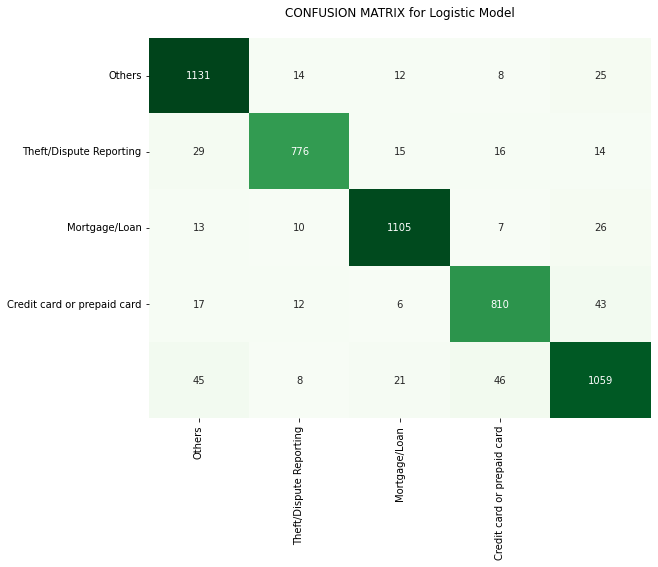

In [54]:
## Logistic model evaluation
# Evaluate the Naive Bayes classifier
model_eval(y_test, logistic_model_pred, "Logistic Model")

# Model 2: Decision Tree

In [55]:
dt = DecisionTreeClassifier()

In [56]:
# Hyperparameter tuning for best result
param_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth' : [5, 10, 15, 20, 25, 30],
    'min_samples_leaf':[1,5,10,15, 20, 25],
    
}

grid_dt = GridSearchCV(estimator=dt, 
                       param_grid=param_dt,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=5)
grid_dt.fit(X_train, y_train)
print(grid_dt.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
{'criterion': 'gini', 'max_depth': 30, 'min_samples_leaf': 10}


In [57]:
# Creating model with best hyperparameter
decision_tree_model = DecisionTreeClassifier(criterion='gini', 
                                      max_depth=25, 
                                      min_samples_leaf=15, 
                                      )
decision_tree_model.fit(X_train, y_train)
y_pred_dt_tuned = decision_tree_model.predict(X_test)

0.8015586229974175
CLASSIFICATION REPORT for Decision Tree Classifier

                             precision    recall  f1-score   support

                     Others       0.81      0.81      0.81      1190
    Theft/Dispute Reporting       0.81      0.81      0.81       850
              Mortgage/Loan       0.79      0.88      0.83      1161
Credit card or prepaid card       0.80      0.80      0.80       888
      Bank Account services       0.81      0.71      0.76      1179

                   accuracy                           0.80      5268
                  macro avg       0.80      0.80      0.80      5268
               weighted avg       0.80      0.80      0.80      5268



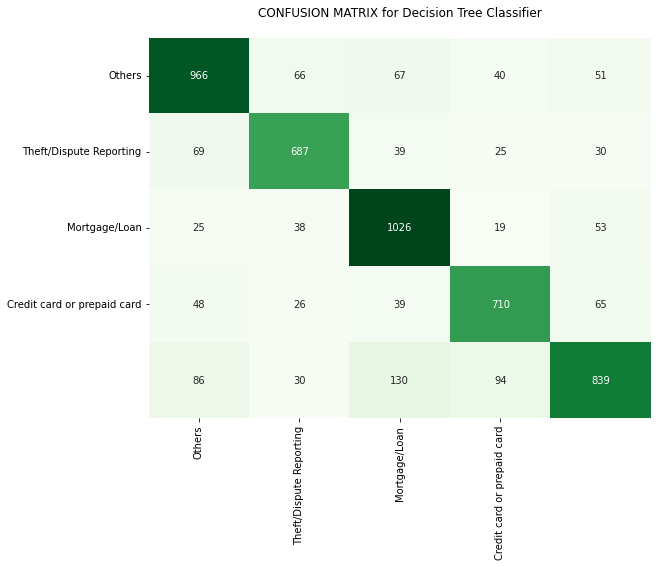

In [58]:
# Evaluate the tuned Decision Tree classifier
model_eval(y_test, y_pred_dt_tuned, "Decision Tree Classifier")

# Model 3 : Random Forest

In [59]:
# Define the parameter grid for grid search
param_grid = {'n_estimators': [100,500,1000], 'max_depth': [50,100,200]}

# Initialize the random forest model
rf_model = RandomForestClassifier()

# Initialize the grid search
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print(grid_search.best_params_)
print(grid_search.best_score_)

{'max_depth': 200, 'n_estimators': 1000}
0.7944183862661631


In [60]:
# Creating model with best hyperparameter
random_forest_model = RandomForestClassifier(n_estimators=1000, 
                                      max_depth=200, 
                                       
                                      )
random_forest_model.fit(X_train, y_train)
y_pred_random_forest = random_forest_model.predict(X_test)

F1-Score for Random Forest Model

0.7784101751714781
CLASSIFICATION REPORT for Random Forest Model

                             precision    recall  f1-score   support

                     Others       0.70      0.92      0.80      1190
    Theft/Dispute Reporting       0.86      0.70      0.77       850
              Mortgage/Loan       0.85      0.90      0.87      1161
Credit card or prepaid card       0.87      0.52      0.65       888
      Bank Account services       0.75      0.79      0.77      1179

                   accuracy                           0.78      5268
                  macro avg       0.81      0.77      0.77      5268
               weighted avg       0.80      0.78      0.78      5268



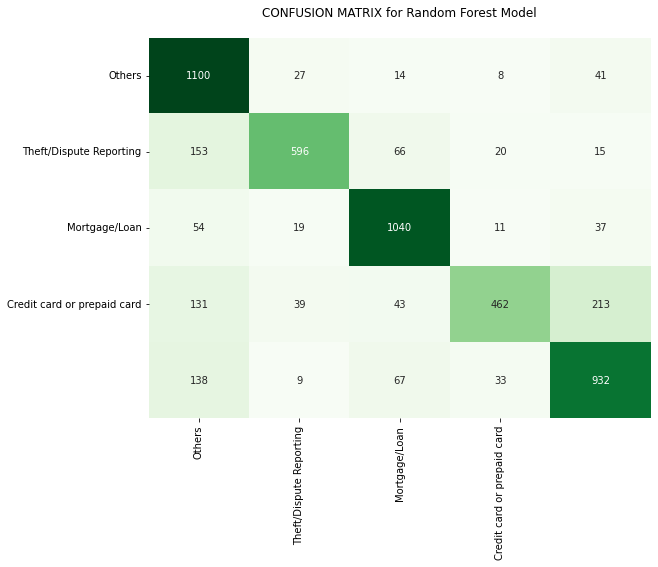

In [65]:
# Evaluate the Random forest model
model_eval(y_test, y_pred_random_forest, "Random Forest Model")

# Model 4: Naive Bayes Classifier

In [66]:
naive_bayes_model = MultinomialNB()
naive_bayes_model.fit(X_train, y_train)
y_pred_naive_bayes = naive_bayes_model.predict(X_test)

F1-Score for Naive Bayes Model is 0.579988667870415
CLASSIFICATION REPORT for Naive Bayes Model

                             precision    recall  f1-score   support

                     Others       0.55      0.90      0.69      1190
    Theft/Dispute Reporting       0.85      0.37      0.51       850
              Mortgage/Loan       0.72      0.88      0.79      1161
Credit card or prepaid card       0.92      0.05      0.10       888
      Bank Account services       0.61      0.77      0.68      1179

                   accuracy                           0.64      5268
                  macro avg       0.73      0.59      0.55      5268
               weighted avg       0.71      0.64      0.58      5268



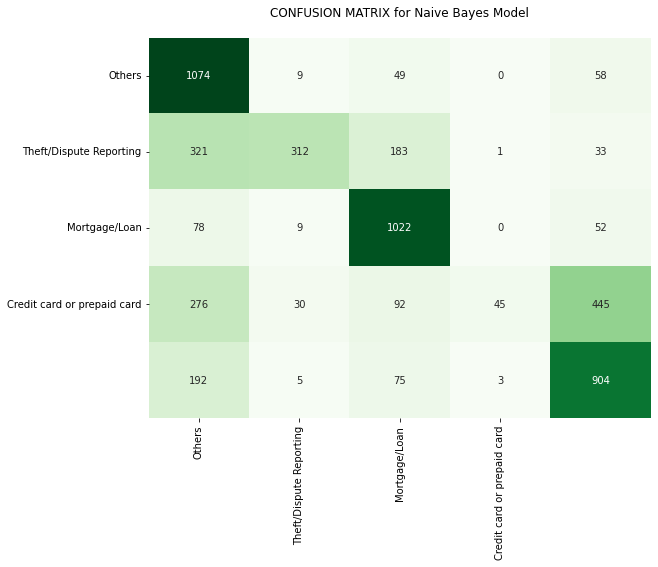

In [72]:
# Evaluate the Random forest model
model_eval(y_test, y_pred_naive_bayes, "Naive Bayes Model")

## Out of all 4 Models, Logistic regression performed well with F1-Score of 92.6%